In [ ]:
import os
import glob
import random
import argparse
import logging
import cv2
import numpy as np
import statistics
from typing import List, Tuple

In [ ]:
# ───────────────────────────────────────────────────────────────────────
# CONFIGURATION (constants)
# ───────────────────────────────────────────────────────────────────────
ADAPTIVE_BLOCK_SIZE = 31
ADAPTIVE_C = -1
LAB_A_THR, LAB_B_THR, LAB_B_MIN = 30, 60, 10
LAB_L_MIN, LAB_L_MAX = 90, 200
GLARE_V_THR, GLARE_S_THR = 180, 80
USE_CLAHE = False
CLAHE_CLIP, CLAHE_GRID = 2.0, (8, 8)
KERNEL_SMALL = np.ones((3, 3), np.uint8)
KERNEL_LARGE = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
DIFF_THRESH = 32

logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s [%(levelname)s] %(message)s")

In [ ]:

# ───────────────────────────────────────────────────────────────────────
# UTILITY FUNCTIONS
# ───────────────────────────────────────────────────────────────────────
def detect_jar_circle_and_mask(img_bgr: np.ndarray):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    circles = cv2.HoughCircles(blur, cv2.HOUGH_GRADIENT, dp=1.2, minDist=1000,
                               param1=50, param2=30, minRadius=100, maxRadius=1550)
    if circles is None:
        raise RuntimeError("No jar circle found.")
    x, y, r = max(np.round(circles[0]).astype(int), key=lambda c: c[2])
    mask = np.zeros_like(gray, dtype=np.uint8)
    cv2.circle(mask, (x, y), r, 255, -1)
    return mask, cv2.bitwise_and(img_bgr, img_bgr, mask=mask)


def lab_adaptive_glare_mask(inside_bgr: np.ndarray):
    lab = cv2.cvtColor(inside_bgr, cv2.COLOR_BGR2LAB)
    L, A, B = cv2.split(lab)
    bg = cv2.GaussianBlur(L, (101, 101), 0)
    L_flat = cv2.divide(L, bg, scale=255).astype(np.uint8)
    adapt = cv2.adaptiveThreshold(L_flat, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY, ADAPTIVE_BLOCK_SIZE, ADAPTIVE_C)
    a = A.astype(int) - 128
    b = B.astype(int) - 128
    lab_mask = ((np.abs(a) < LAB_A_THR) & (np.abs(b) < LAB_B_THR)
                & (b >= LAB_B_MIN) & (L > LAB_L_MIN) & (L < LAB_L_MAX)).astype(np.uint8) * 255
    hsv = cv2.cvtColor(inside_bgr, cv2.COLOR_BGR2HSV)
    S, V = hsv[:, :, 1], hsv[:, :, 2]
    if USE_CLAHE:
        clahe = cv2.createCLAHE(clipLimit=CLAHE_CLIP, tileGridSize=CLAHE_GRID)
        V = clahe.apply(V)
    glare = ((V > GLARE_V_THR) & (S < GLARE_S_THR))
    not_glare = (~glare).astype(np.uint8) * 255
    combined = cv2.bitwise_and(adapt, lab_mask)
    combined = cv2.bitwise_and(combined, not_glare)
    clean = cv2.morphologyEx(combined, cv2.MORPH_OPEN, KERNEL_SMALL)
    return cv2.morphologyEx(clean, cv2.MORPH_CLOSE, KERNEL_SMALL)


def temporal_diff_mask(cur_gray: np.ndarray, ref_gray: np.ndarray):
    diff = cv2.absdiff(cur_gray, ref_gray)
    _, binar = cv2.threshold(diff, DIFF_THRESH, 255, cv2.THRESH_BINARY)
    opened = cv2.morphologyEx(binar, cv2.MORPH_OPEN, KERNEL_LARGE)
    return cv2.morphologyEx(opened, cv2.MORPH_CLOSE, KERNEL_LARGE)


def keep_largest_contour(mask: np.ndarray):
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return mask
    largest = max(contours, key=cv2.contourArea)
    out = np.zeros_like(mask)
    cv2.drawContours(out, [largest], -1, 255, cv2.FILLED)
    return out

Reference (Day 1): cam1_05-07_15-00.jpg
Testing on: ['cam1_05-17_01-00.jpg', 'cam1_05-10_03-00.jpg', 'cam1_05-07_19-00.jpg', 'cam1_05-09_14-00.jpg', 'cam1_05-20_02-00.jpg']


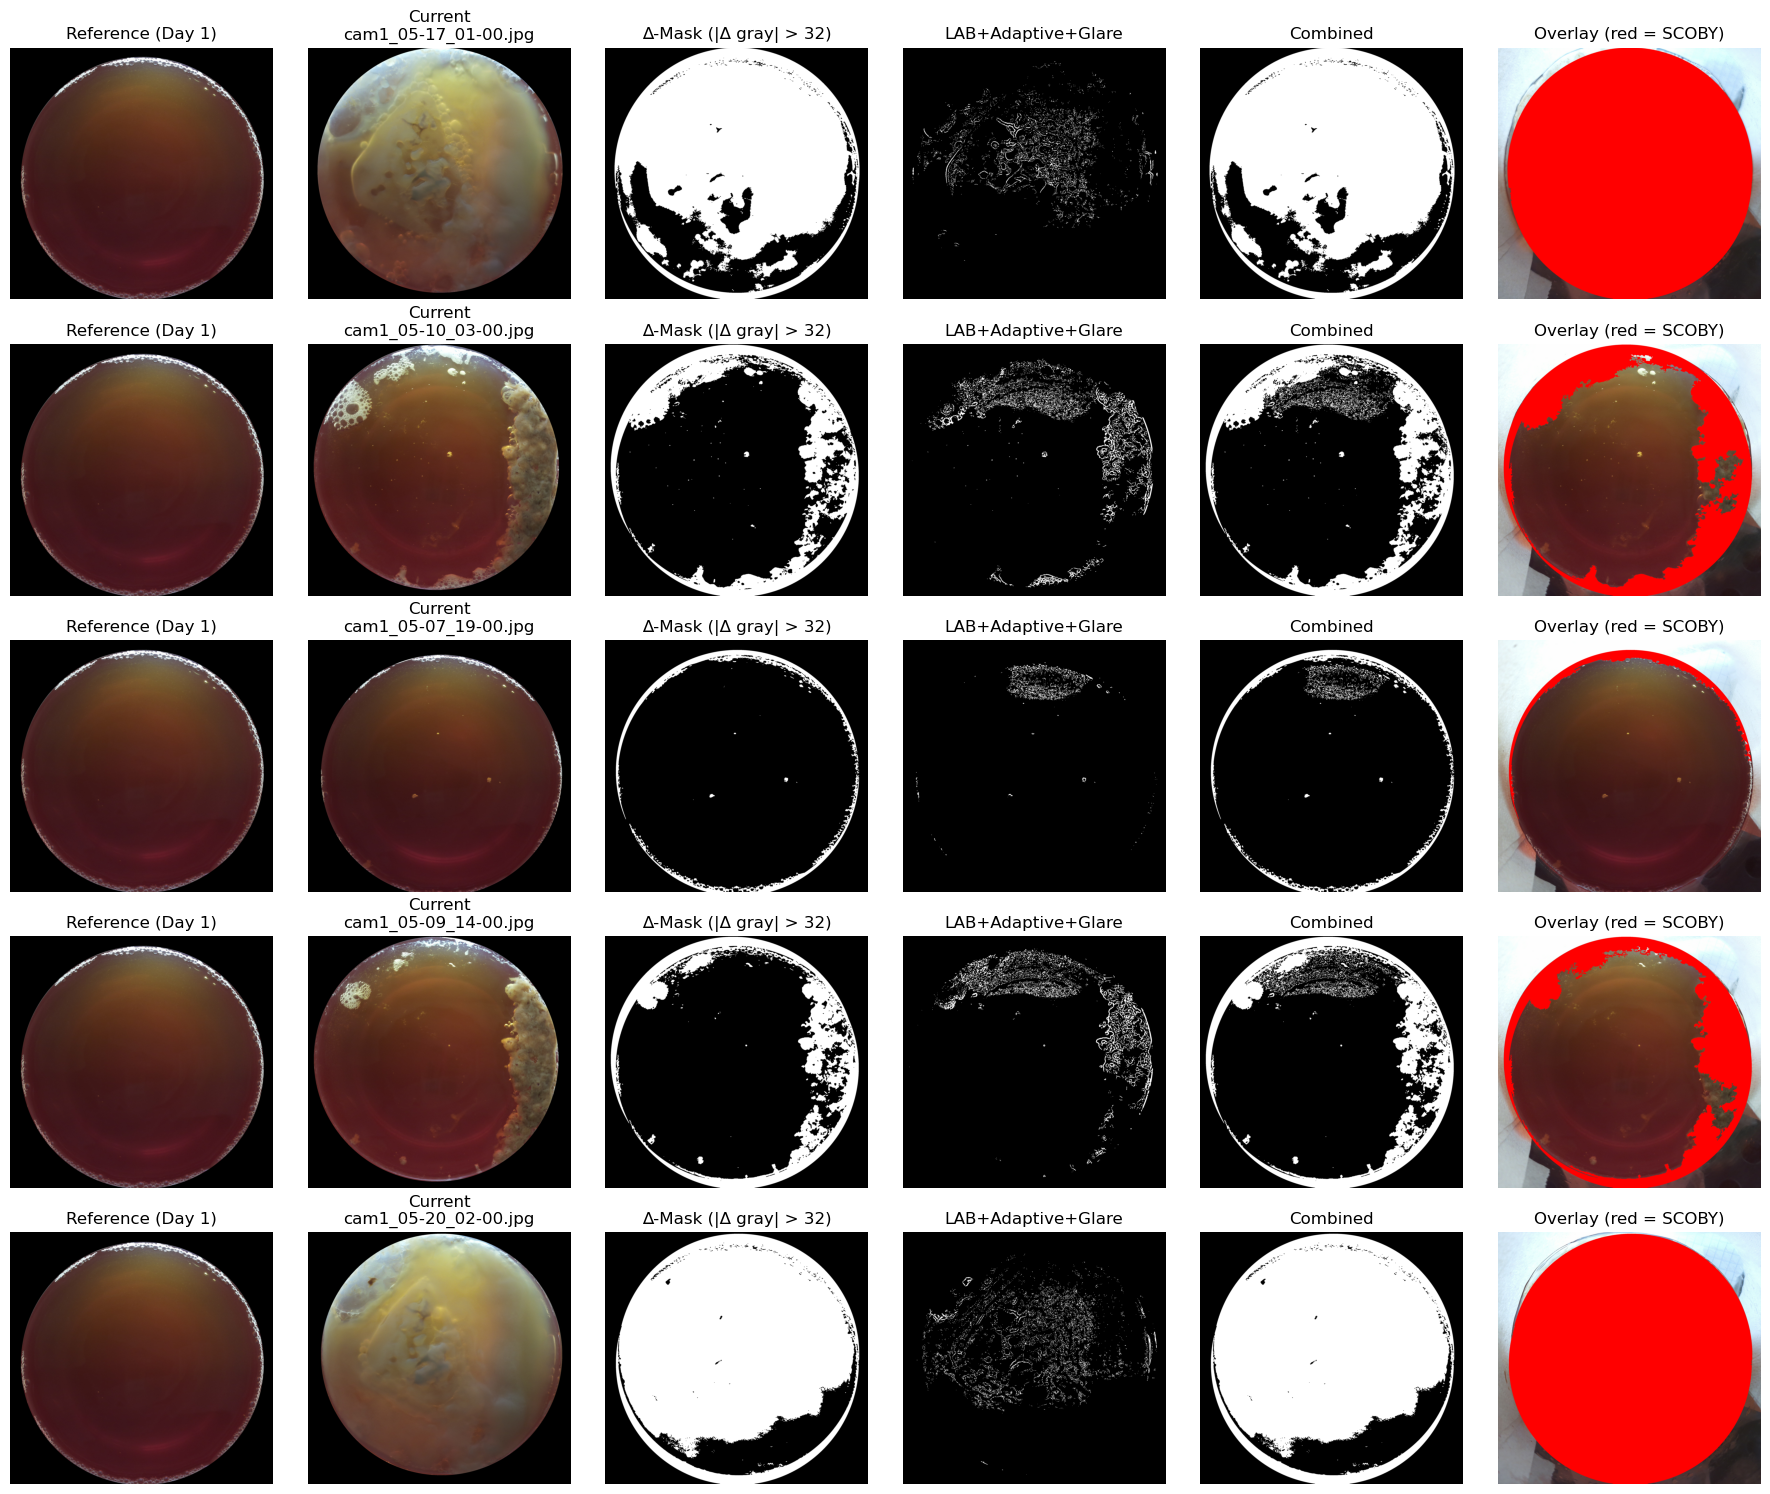

In [ ]:
# Specify data directory for images
image_dir = "data/Experiment_6/exp6_cam1/exp6_cam1_cropped_14d"

# Cell 2: Visualize 5 Random Samples
paths = sorted(glob.glob(os.path.join(image_dir, "*.jpg")) +
               glob.glob(os.path.join(image_dir, "*.png")))
assert len(paths) >= 2, "Need at least 2 images."
ref_img = cv2.imread(paths[0]); _, ref_in = detect_jar_circle_and_mask(ref_img)
ref_gray = cv2.cvtColor(ref_in, cv2.COLOR_BGR2GRAY)
samples = random.sample(paths[1:], min(5, len(paths)-1))

fig, axes = plt.subplots(len(samples), 6, figsize=(18, 3*len(samples)))
if len(samples) == 1:
    axes = np.expand_dims(axes, 0)
for i, p in enumerate(samples):
    img = cv2.imread(p); _, inside = detect_jar_circle_and_mask(img)
    gray = cv2.cvtColor(inside, cv2.COLOR_BGR2GRAY)
    td = temporal_diff_mask(gray, ref_gray)
    la = lab_adaptive_glare_mask(inside)
    combined = cv2.bitwise_or(td, la)
    final = keep_largest_contour(combined)
    overlay = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    overlay[final == 255] = (255, 0, 0)

    axs = axes[i]
    axs[0].imshow(cv2.cvtColor(ref_in, cv2.COLOR_BGR2RGB)); axs[0].axis('off'); axs[0].set_title('Reference (Day 1)')
    axs[1].imshow(cv2.cvtColor(inside, cv2.COLOR_BGR2RGB)); axs[1].axis('off'); axs[1].set_title(f'Current\n{os.path.basename(p)}')
    axs[2].imshow(td, cmap='gray'); axs[2].axis('off'); axs[2].set_title(f'Δ-Mask (|Δ gray| > {DIFF_THRESH})')
    axs[3].imshow(la, cmap='gray'); axs[3].axis('off'); axs[3].set_title('LAB+Adaptive+Glare')
    axs[4].imshow(combined, cmap='gray'); axs[4].axis('off'); axs[4].set_title('Combined')
    axs[5].imshow(overlay); axs[5].axis('off'); axs[5].set_title('Overlay (red = SCOBY)')

plt.tight_layout()
plt.show()

In [ ]:
# Cell 3: Batch Generate & Save Masks
output_dir = "masks/cam1"
os.makedirs(output_dir, exist_ok=True)
for p in paths[1:]:
    img = cv2.imread(p)
    if img is None:
        logging.warning(f"Skipping {p}")
        continue
    _, inside = detect_jar_circle_and_mask(img)
    gray = cv2.cvtColor(inside, cv2.COLOR_BGR2GRAY)
    td = temporal_diff_mask(gray, ref_gray)
    la = lab_adaptive_glare_mask(inside)
    combined = cv2.bitwise_or(td, la)
    final = keep_largest_contour(combined)
    name = os.path.splitext(os.path.basename(p))[0] + "_mask.png"
    out_path = os.path.join(output_dir, name)
    cv2.imwrite(out_path, final)
    logging.info(f"Saved mask: {out_path}")

Day 1 reference: cam1_05-07_15-00.jpg
Will generate masks for 345 images…
Saved mask → masks/cam1\cam1_05-07_16-00_mask.png
Saved mask → masks/cam1\cam1_05-07_17-00_mask.png
Saved mask → masks/cam1\cam1_05-07_18-00_mask.png
Saved mask → masks/cam1\cam1_05-07_19-00_mask.png
Saved mask → masks/cam1\cam1_05-07_20-00_mask.png
Saved mask → masks/cam1\cam1_05-07_21-00_mask.png
Saved mask → masks/cam1\cam1_05-07_22-00_mask.png
Saved mask → masks/cam1\cam1_05-07_23-00_mask.png
Saved mask → masks/cam1\cam1_05-08_00-00_mask.png
Saved mask → masks/cam1\cam1_05-08_01-00_mask.png
Saved mask → masks/cam1\cam1_05-08_02-00_mask.png
Saved mask → masks/cam1\cam1_05-08_03-00_mask.png
Saved mask → masks/cam1\cam1_05-08_04-00_mask.png
Saved mask → masks/cam1\cam1_05-08_05-00_mask.png
Saved mask → masks/cam1\cam1_05-08_06-00_mask.png
Saved mask → masks/cam1\cam1_05-08_07-00_mask.png
Saved mask → masks/cam1\cam1_05-08_08-00_mask.png
Saved mask → masks/cam1\cam1_05-08_09-00_mask.png
Saved mask → masks/cam1\ca